# Anticipez les besoins en consommation de bâtiments - *Notebook prediction TotalGHGEmissions*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :


1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

In [115]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables catégorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, make_scorer, r2_score, mean_absolute_error

from sklearn import dummy
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.svm import SVR

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

from sklearn.inspection import permutation_importance
import shap
shap.initjs()

import timeit
import warnings
from packaging.version import parse as parse_version

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)
print("shap version", shap.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0
shap version 0.46.0


## 1 - Création des fonctions et paramètres pour automatisation

### 1.1 - Fonction des modèles avec validation croisée

**Validation croisée avec le modèle Lasso**

In [6]:
def fit_GridSearchCV_lasso(X_train, y_train, scoring, param_grid):

    # Initialisation de GridSearchCV
    grid_search = GridSearchCV(
        estimator=Lasso(),           # une régression Lasso
        param_grid=param_grid,
        cv=5,                        # nombre de folds
        scoring=scoring,
        refit='R2',                  # Refit avec la meilleure valeur de R²
        #n_jobs=-1,                  # Utilisation de tous les cœurs disponibles
        verbose=1
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle ElasticNet**

In [8]:
def fit_GridSearchCV_elasticNet(X_train, y_train, scoring, param_grid):

    # Initialisation de GridSearchCV
    grid_search = GridSearchCV(
        estimator=ElasticNet(),           # une régression ElasticNet
        param_grid=param_grid,
        cv=5,                        # nombre de folds
        scoring=scoring,
        refit='R2',                  # Refit avec la meilleure valeur de R²
        #n_jobs=-1,                  # Utilisation de tous les cœurs disponibles
        verbose=1
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle GradientBoostingRegressor**

In [10]:
def fit_GridSearchCV_GradientBoostingRegressor(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec le modèle RamdomForestRegressor**

In [12]:
def fit_GridSearchCV_ramdomForestRegressor(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

**Validation croisée avec SVR**

In [14]:
def fit_GridSearchCV_SVR(X_train, y_train, scoring, param_grid):

    # Configuration de GridSearchCV
    grid_search = GridSearchCV(
        estimator=SVR(),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # Validation croisée à 5 plis
        refit='R2',
        n_jobs=-1,  # Utilisation de tous les cœurs disponibles
        verbose=1  # Affichage des détails
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search

### 1.2 - Fonctions d'affichage des résultats

Affichage simple du résultat (meilleurs paramètres, scores,...) d'une validation croisée

In [16]:
def print_result_CV(grid_search):

    # Afficher les meilleurs paramètres trouvés
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    
    # Afficher le meilleur score
    print("Meilleu(s) score sur le jeu d'entraînement:")
    print(grid_search.best_score_)
    
    # Utiliser le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for score_name in scoring.keys():
        
        print(f"\nScores pour '{score_name}':")    
        for mean, std, params, mean_fit_time in zip(
                grid_search.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
                grid_search.cv_results_[f'std_test_{score_name}'],   # écart-type du score
                grid_search.cv_results_['params'],                   # valeur de l'hyperparamètre
                grid_search.cv_results_['mean_fit_time']             # temps moyen d'entraînement
        ):
            print(f"{score_name} = {mean:.3f} (+/-{std * 2:.03f}) for {params}")

Affichage sous forme de dataframe du résultat (meilleurs paramètres, scores,...) d'une validation croisée, pour plus de lisibilité

In [18]:
def print_result_CV_as_dataframe(grid_search, scoring):

    # Liste pour stocker les résultats
    results = []
    
    # Afficher les performances correspondantes
    print("Résultats de la validation croisée :")
    for score_name in scoring.keys():
           
        for mean, std, params, mean_fit_time in zip(
                grid_search.cv_results_[f'mean_test_{score_name}'],  # score moyen pour chaque score
                grid_search.cv_results_[f'std_test_{score_name}'],   # écart-type du score
                grid_search.cv_results_['params'],                   # valeur de l'hyperparamètre
                grid_search.cv_results_['mean_fit_time']             # temps moyen d'entraînement
        ):
                    
            # Ajouter chaque combinaison de résultats à une liste sous forme de dictionnaire
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })
    
    # Transformer en DataFrame
    df_results = pd.DataFrame(results)
    
    # Convertir la colonne 'params' en chaîne de caractères
    df_results['params'] = df_results['params'].apply(str)
    
    # Transformation avec pivot
    df_results = df_results.pivot(
        index='params',                             # Les paramètres deviennent l'index
        columns='score_name',                       # Les valeurs uniques de score_name deviennent des colonnes
        values=['mean_score', 'mean_fit_time']      # Les valeurs à remplir dans les colonnes (ici, mean_score)
    ).reset_index()
    
    # Aplatir les colonnes multi-indexées
    df_results.columns = ['_'.join(col).strip() for col in df_results.columns.values]
    
    # Réinitialiser l'index pour obtenir un DataFrame "normal"
    df_results = df_results.reset_index()
    df_results.drop(columns=['index'], inplace=True)
    
    # Supprimer l'axe des index
    df_results = df_results.rename_axis(None, axis=1)
    
    # On trie le dataframe sur la colonne R2 du pmus grand au plus petit
    df_results.sort_values(by='mean_score_R2', ascending=False, inplace=True)
    df_results = df_results.reset_index()
    df_results.drop(columns=['index', 'mean_fit_time_MAE', 'mean_fit_time_RMSE'], inplace=True)
    df_results.rename(columns={'mean_fit_time_R2': 'mean_fit_time'}, inplace=True)
    
    return df_results

Affichage des scores calculés sur le fichier de test avec le modèle de la meilleure performance de la validation croisée

In [20]:
def print_result_CV_on_test_file(X_test, y_test, grid_search):

    # Utiliser le modèle avec les meilleurs paramètres
    best_model = grid_search.best_estimator_
    
    # Prédictions avec le modèle optimisé
    y_pred = best_model.predict(X_test)
    
    # Évaluation du modèle avec différentes métriques
    mse = round(mean_squared_error(y_test, y_pred), 2)       # Erreur quadratique moyenne
    rmse = round(np.sqrt(mse), 2)                            # Racine carrée de l'erreur quadratique moyenne (RMSE)
    mae = round(mean_absolute_error(y_test, y_pred), 2)      # Erreur absolue moyenne
    r2 = round(r2_score(y_test, y_pred), 2)                  # Coefficient de détermination
    
    scores_cv_fe1 = np.array([[mse, rmse, r2, mae]])
    
    # Conversion de l'array en DataFrame
    df_scores_cv_fe1 = pd.DataFrame(scores_cv_fe1, columns=['MSE', 'RMSE', 'R2', 'MAE'])
    
    # on transforme la colonne R2 en numérique
    df_scores_cv_fe1['R2'] = pd.to_numeric(df_scores_cv_fe1['R2'], errors='coerce')
    
    # On trie le dataframe sur la colonne R2 du pmus grand au plus petit
    df_scores_cv_fe1.sort_values(by='R2', ascending=False, inplace=True)
    
    return df_scores_cv_fe1    

### 1.3 - Paramètres

In [22]:
pd.set_option('display.float_format', '{:.3f}'.format)  # Désactiver l'écriture scientifique

Créons une fonction pour calculer le RMSE qui n'a pas directement disponible dans le GridSearchCV :

In [24]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)  # False car on minimise le RMSE

In [26]:
# Définition du dictionnaire des métriques de scoring
scoring = {
    'MAE': 'neg_mean_absolute_error',  # Utilise l'erreur absolue moyenne
    'R2': 'r2',                        # Utilise le coefficient de détermination
    'RMSE': rmse_scorer                # Utilise Root Mean Squared Error (racine carré de l'erreur quadratique moyenne)
}

### 2 - Simulation des modèles et choix du modèle final

On repart du dataset issu du 2ème feature engineering

In [28]:
# Charger le fichier de données
data_fe2 = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_fe2.csv", sep=',', low_memory=False)
data_fe2.head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Neighborhood_BALLARD,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,"YearBuilt_Bin_(1899.885, 1911.5]","YearBuilt_Bin_(1911.5, 1923.0]","YearBuilt_Bin_(1923.0, 1934.5]","YearBuilt_Bin_(1934.5, 1946.0]","YearBuilt_Bin_(1946.0, 1957.5]","YearBuilt_Bin_(1957.5, 1969.0]","YearBuilt_Bin_(1969.0, 1980.5]","YearBuilt_Bin_(1980.5, 1992.0]","YearBuilt_Bin_(1992.0, 2003.5]","YearBuilt_Bin_(2003.5, 2015.0]",PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,electricity_percent,gaz_percent,steam_percent,usage_Autres,usage_Bureaux & Espaces de travail,usage_Commerce & Retail,usage_Entrepôts et Logistique,usage_Hébergement & Logement,usage_Loisirs et Divertissement,usage_Restauration,usage_Services publics & Infrastructure,usage_Soins médicaux,usage_Transports & Parking,usage_Éducation,PropertyGFAOutsideParking
0,1.000,12,0,7456910.000,249.980,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,54.610,17.660,27.730,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,88434.000
1,1.000,11,15064,8664479.000,295.860,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,38.660,61.340,0.000,0.000,0.000,0.000,0.000,80.990,0.000,4.460,0.000,0.000,14.550,0.000,88502.000
2,1.000,10,0,6946800.500,286.430,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,40.750,26.660,32.590,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,61320.000
3,1.000,18,62000,14656503.000,505.010,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,37.880,62.120,0.000,0.000,0.000,0.000,0.000,64.480,0.000,0.000,0.000,0.000,35.520,0.000,113580.000
4,1.000,2,37198,12581712.000,301.810,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,60.990,39.010,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,60090.000


In [29]:
data_fe2.shape

(1440, 66)

#### 2.1 - Préparation

**Sélection de la cible**

In [31]:
y_fe2_emissions = data_fe2['TotalGHGEmissions']
X_fe2 = data_fe2.drop('TotalGHGEmissions', axis=1, inplace=False)
X_fe2 = X_fe2.drop('SiteEnergyUseWN(kBtu)', axis=1, inplace=False)
X_fe2.shape

(1440, 64)

**Standardisation et création jeux d'entrainement et test**

In [33]:
X_scale_fe2 = StandardScaler().fit_transform(X_fe2)

df = pd.DataFrame(X_scale_fe2)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
count,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000,1440.000
mean,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.132,-0.820,-0.288,-0.216,-0.184,-0.175,-0.026,-0.481,-0.278,-0.542,-0.303,-0.315,-0.216,-0.288,-0.239,-0.175,-0.165,-0.341,-0.290,-0.324,-0.184,-0.350,-0.434,-0.361,-0.347,-0.355,-0.311,-0.192,-0.026,-0.209,-0.306,-0.053,-0.278,-0.037,-0.141,-0.269,-0.046,-0.415,-0.088,-0.119,-0.088,-0.247,-0.138,-0.103,-0.495,-0.165,-0.103,-0.385,-0.221,-2.599,-1.092,-0.202,-0.269,-0.761,-0.414,-0.523,-0.301,-0.159,-0.158,-0.296,-0.094,-0.367,-0.345,-1.049
25%,-0.132,-0.553,-0.288,-0.216,-0.184,-0.175,-0.026,-0.481,-0.278,-0.542,-0.303,-0.315,-0.216,-0.288,-0.239,-0.175,-0.165,-0.341,-0.290,-0.324,-0.184,-0.350,-0.434,-0.361,-0.347,-0.355,-0.311,-0.192,-0.026,-0.209,-0.306,-0.053,-0.278,-0.037,-0.141,-0.269,-0.046,-0.415,-0.088,-0.119,-0.088,-0.247,-0.138,-0.103,-0.495,-0.165,-0.103,-0.385,-0.221,-0.803,-1.092,-0.202,-0.269,-0.761,-0.414,-0.523,-0.301,-0.159,-0.158,-0.296,-0.094,-0.367,-0.345,-0.622
50%,-0.132,-0.286,-0.288,-0.216,-0.184,-0.175,-0.026,-0.481,-0.278,-0.542,-0.303,-0.315,-0.216,-0.288,-0.239,-0.175,-0.165,-0.341,-0.290,-0.324,-0.184,-0.350,-0.434,-0.361,-0.347,-0.355,-0.311,-0.192,-0.026,-0.209,-0.306,-0.053,-0.278,-0.037,-0.141,-0.269,-0.046,-0.415,-0.088,-0.119,-0.088,-0.247,-0.138,-0.103,-0.495,-0.165,-0.103,-0.385,-0.221,0.001,-0.084,-0.202,-0.269,-0.761,-0.414,-0.523,-0.301,-0.159,-0.158,-0.296,-0.094,-0.367,-0.345,-0.357
75%,-0.132,0.247,-0.288,-0.216,-0.184,-0.175,-0.026,-0.481,-0.278,-0.542,-0.303,-0.315,-0.216,-0.288,-0.239,-0.175,-0.165,-0.341,-0.290,-0.324,-0.184,-0.350,-0.434,-0.361,-0.347,-0.355,-0.311,-0.192,-0.026,-0.209,-0.306,-0.053,-0.278,-0.037,-0.141,-0.269,-0.046,-0.415,-0.088,-0.119,-0.088,-0.247,-0.138,-0.103,-0.495,-0.165,-0.103,-0.385,-0.221,1.159,0.818,-0.202,-0.269,0.913,-0.414,-0.523,-0.301,-0.159,-0.158,-0.296,-0.094,-0.367,-0.345,0.178
max,12.515,25.594,12.040,4.637,5.444,5.700,37.934,2.077,3.603,1.845,3.302,3.174,4.637,3.477,4.179,5.700,6.074,2.933,3.443,3.084,5.444,2.859,2.306,2.770,2.879,2.819,3.215,5.219,37.934,4.796,3.272,18.947,3.603,26.814,7.101,3.721,21.886,2.407,11.398,8.426,11.398,4.043,7.234,9.747,2.022,6.074,9.747,2.597,4.527,1.159,2.652,9.046,4.509,1.834,3.037,2.199,3.859,8.574,10.992,3.805,11.920,6.989,2.988,5.912


In [34]:
# 25% des données dans le jeu de test
X_fe2_train, X_fe2_test, y_fe2_train, y_fe2_test = model_selection.train_test_split(X_scale_fe2, y_fe2_emissions, test_size=0.25, random_state=42 )

#### 2-2 - modèle Lasso

In [36]:
# Définition des hyperparamètres à tester
param_grid = {
    'alpha': np.logspace(-6, 6, 13) 
}

In [37]:
warnings.filterwarnings("ignore")

grid_search_fe2_lasso = fit_GridSearchCV_lasso(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_lasso, scoring).head(30)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,{'alpha': 1.0},-39.689,0.536,-64.773,0.004
1,{'alpha': 0.1},-40.669,0.531,-65.114,0.015
2,{'alpha': 0.01},-40.887,0.529,-65.198,0.076
3,{'alpha': 0.001},-40.912,0.529,-65.207,0.111
4,{'alpha': 0.0001},-40.914,0.529,-65.209,0.097
5,{'alpha': 1e-05},-40.914,0.529,-65.209,0.084
6,{'alpha': 1e-06},-40.914,0.529,-65.209,0.096
7,{'alpha': 10.0},-43.818,0.435,-71.548,0.003
8,{'alpha': 100.0},-66.325,-0.006,-95.453,0.001
9,{'alpha': 1000.0},-66.325,-0.006,-95.453,0.004


Sur le fichier de test :

In [39]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_lasso).head(30)

,MSE,RMSE,R2,MAE
0,4086.620,63.930,0.550,40.760


#### 2-3 - modèle ElasticNet

In [41]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Grille pour alpha
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # Grille pour l1_ratio
}

In [42]:
grid_search_fe2_elasticNet = fit_GridSearchCV_elasticNet(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_elasticNet, scoring).head(30)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'alpha': 1.0, 'l1_ratio': 1.0}",-39.689,0.536,-64.773,0.003
1,"{'alpha': 1.0, 'l1_ratio': 0.9}",-39.573,0.533,-65.051,0.000
2,"{'alpha': 0.1, 'l1_ratio': 0.7}",-40.413,0.532,-65.053,0.025
3,"{'alpha': 0.1, 'l1_ratio': 0.5}",-40.324,0.532,-65.070,0.009
4,"{'alpha': 0.1, 'l1_ratio': 0.9}",-40.550,0.531,-65.078,0.032
5,"{'alpha': 0.1, 'l1_ratio': 1.0}",-40.669,0.531,-65.114,0.014
6,"{'alpha': 0.1, 'l1_ratio': 0.1}",-40.222,0.530,-65.175,0.008
7,"{'alpha': 0.01, 'l1_ratio': 0.1}",-40.751,0.530,-65.144,0.034
8,"{'alpha': 0.01, 'l1_ratio': 0.5}",-40.804,0.530,-65.164,0.026
9,"{'alpha': 0.01, 'l1_ratio': 0.7}",-40.835,0.530,-65.176,0.032


Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [44]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_elasticNet).head(30)

,MSE,RMSE,R2,MAE
0,4086.620,63.930,0.550,40.760


#### 2.4 - modèle GradientBoostingRegressor

In [46]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.01, 0.1, 0.2], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 5, 7], # Profondeur maximale de chaque arbre
    'subsample': [0.8, 1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [47]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.858,0.630,-57.911,1.779
1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.268,0.626,-58.148,2.033
2,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",-32.635,0.626,-58.277,1.002
3,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-34.281,0.625,-58.292,1.582
4,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.511,0.622,-58.522,1.077
5,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",-33.298,0.617,-58.958,1.898
6,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",-33.222,0.616,-59.004,1.195
7,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",-32.997,0.615,-59.065,2.358
8,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",-33.188,0.614,-59.103,3.586
9,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",-33.479,0.613,-59.238,1.866


Les R2 sont meilleurs avec le GradientBoosting que le Lasso et l'ElasticNet, mais le temps de traitement est plus long.

Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [49]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_gradient).head(30)

,MSE,RMSE,R2,MAE
0,3826.490,61.860,0.580,36.670


Par contre le résultat sur le fichier de test est moins bons que lors de la validation croisée.

#### 2.5 - Modèle RamdomForestRegressor

In [52]:
param_grid = {
    'n_estimators': [100, 200, 300],  # nombre d'arbres dans la forêt.
    'max_depth': [None, 10, 20, 30],   # profondeur maximale des arbres
}

In [53]:
grid_search_fe2_ramdomForest = fit_GridSearchCV_ramdomForestRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_ramdomForest, scoring).head(30)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'max_depth': None, 'n_estimators': 300}",-32.865,0.611,-59.428,10.467
1,"{'max_depth': 20, 'n_estimators': 300}",-32.871,0.611,-59.430,10.226
2,"{'max_depth': 20, 'n_estimators': 200}",-32.914,0.610,-59.469,6.766
3,"{'max_depth': 30, 'n_estimators': 300}",-32.886,0.610,-59.472,8.779
4,"{'max_depth': None, 'n_estimators': 200}",-32.924,0.610,-59.491,6.557
5,"{'max_depth': 30, 'n_estimators': 200}",-32.952,0.609,-59.545,7.067
6,"{'max_depth': 20, 'n_estimators': 100}",-33.034,0.609,-59.542,3.443
7,"{'max_depth': None, 'n_estimators': 100}",-33.037,0.608,-59.656,3.336
8,"{'max_depth': 30, 'n_estimators': 100}",-33.071,0.607,-59.656,3.332
9,"{'max_depth': 10, 'n_estimators': 100}",-34.052,0.595,-60.563,2.391


Les scores sont moins bons, et surtout les temps de traitement sont beaucoup plus longs!

Résultat sur le Résultat sur le fichier de test avec les meilleurs hyperparamètres :

In [55]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_ramdomForest).head(30)

,MSE,RMSE,R2,MAE
0,3410.150,58.400,0.630,33.630


#### 2.6 - Modèle SVR

In [57]:
param_grid = {
    'C': [0.1, 1, 10, 100],              # Le paramètre de régularisation (contrôle la marge entre biais et variance).
    'epsilon': [0.1, 0.2, 0.5, 1],       # La largeur de la zone d'insensibilité à l'erreur
    'kernel': ['rbf', 'poly', 'linear'], # Le type de noyau utilisé dans le modèle ('linear', 'poly', 'rbf', 'sigmoid')
}

In [58]:
grid_search_fe2_SVR = fit_GridSearchCV_SVR(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_SVR, scoring).head(30)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'C': 100, 'epsilon': 0.2, 'kernel': 'linear'}",-37.230,0.514,-66.371,5.932
1,"{'C': 100, 'epsilon': 0.1, 'kernel': 'linear'}",-37.238,0.514,-66.381,6.928
2,"{'C': 100, 'epsilon': 0.5, 'kernel': 'linear'}",-37.200,0.513,-66.413,9.034
3,"{'C': 100, 'epsilon': 1, 'kernel': 'linear'}",-37.157,0.513,-66.420,8.773
4,"{'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}",-37.118,0.513,-66.448,0.789
5,"{'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}",-37.111,0.513,-66.463,0.911
6,"{'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}",-37.131,0.512,-66.500,1.097
7,"{'C': 10, 'epsilon': 1, 'kernel': 'linear'}",-37.116,0.511,-66.580,1.443
8,"{'C': 100, 'epsilon': 1, 'kernel': 'rbf'}",-35.790,0.500,-67.368,0.283
9,"{'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}",-35.820,0.500,-67.403,0.280


Le résultat du SVR est moins bon que les autres modèles, mais le SVR est plus performant sur cette cible que la cible sur la consommation d'énergie.

#### 2.7 - Choix du modèle final

Le modèle GradientBoostingRegressor est le plus performant (R2 = 0.630)

**Optimisation des hyperparamètres**

Pour rappel voici les hyperparamètres du meilleur R2 :

In [63]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}

On reserre les hyperparamètres :

In [65]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [140, 150, 160],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.08, 0.1, 0.12], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [2, 3, 4], # Profondeur maximale de chaque arbre
    'subsample': [1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [66]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.879,0.636,-57.474,1.743
1,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.891,0.635,-57.545,1.901
2,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.874,0.634,-57.590,1.978
3,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.859,0.630,-57.904,1.646
4,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.858,0.630,-57.911,1.540
5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-33.993,0.628,-58.048,1.369
6,"{'learning_rate': 0.08, 'max_depth': 3, 'n_est...",-33.900,0.626,-58.216,1.687
7,"{'learning_rate': 0.08, 'max_depth': 3, 'n_est...",-33.942,0.626,-58.236,1.561
8,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est...",-32.521,0.625,-58.184,1.889
9,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est...",-32.568,0.625,-58.195,1.781


C'est un peu mieux.

In [68]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 140, 'subsample': 1.0}

In [69]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [135, 140, 145],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.09, 0.1, 0.11], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 4, 5], # Profondeur maximale de chaque arbre
    'subsample': [1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [70]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-32.965,0.638,-57.290,1.700
1,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-32.972,0.637,-57.331,1.831
2,"{'learning_rate': 0.09, 'max_depth': 4, 'n_est...",-32.859,0.637,-57.283,1.751
3,"{'learning_rate': 0.09, 'max_depth': 4, 'n_est...",-32.823,0.637,-57.295,1.813
4,"{'learning_rate': 0.09, 'max_depth': 4, 'n_est...",-32.896,0.637,-57.300,1.664
5,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-32.972,0.637,-57.363,1.771
6,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.839,0.636,-57.424,1.758
7,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.879,0.636,-57.474,1.788
8,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-32.888,0.635,-57.525,1.828
9,"{'learning_rate': 0.09, 'max_depth': 3, 'n_est...",-33.993,0.632,-57.765,1.433


In [71]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 135, 'subsample': 1.0}

C'est encore un peu mieux.

In [73]:
# Définition des hyperparamètres pour la recherche
param_grid = {
    'n_estimators': [132, 135, 138],  # Nombre d'arbres dans l'ensemble.
    'learning_rate': [0.11], # Taux d'apprentissage pour la réduction du poids de chaque arbre
    'max_depth': [3, 4, 5], # Profondeur maximale de chaque arbre
    'subsample': [1.0] # Fraction des échantillons utilisés pour entraîner chaque arbre.
}

In [74]:
grid_search_fe2_gradient = fit_GridSearchCV_GradientBoostingRegressor(X_fe2_train, y_fe2_train, scoring, param_grid)
print_result_CV_as_dataframe(grid_search_fe2_gradient, scoring).head(30)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Résultats de la validation croisée :


,params_,mean_score_MAE,mean_score_R2,mean_score_RMSE,mean_fit_time
0,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-32.965,0.638,-57.290,1.749
1,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-32.955,0.638,-57.319,1.696
2,"{'learning_rate': 0.11, 'max_depth': 4, 'n_est...",-33.001,0.638,-57.322,1.567
3,"{'learning_rate': 0.11, 'max_depth': 3, 'n_est...",-33.937,0.620,-58.709,1.268
4,"{'learning_rate': 0.11, 'max_depth': 3, 'n_est...",-33.963,0.620,-58.716,1.333
5,"{'learning_rate': 0.11, 'max_depth': 3, 'n_est...",-33.939,0.620,-58.716,1.254
6,"{'learning_rate': 0.11, 'max_depth': 5, 'n_est...",-33.260,0.619,-58.763,1.860
7,"{'learning_rate': 0.11, 'max_depth': 5, 'n_est...",-33.264,0.618,-58.790,2.065
8,"{'learning_rate': 0.11, 'max_depth': 5, 'n_est...",-33.252,0.618,-58.806,1.994


Pareil. Et sur le fichier de test :

In [76]:
print_result_CV_on_test_file(X_fe2_test, y_fe2_test, grid_search_fe2_gradient).head(30)

,MSE,RMSE,R2,MAE
0,4072.800,63.820,0.550,35.850


Le score sur le fichier de test est beaucoup moins bon

### 3 - Analyse de la "feature importance" globale et locale

Utilisation de la méthode SHAPE avec le GradientBoostingRegressor

#### 3.1 - Préparation

Récupérons les hyperparamètres du GradientBoostingRegressor optimisé avec la validation croisée :

In [78]:
grid_search_fe2_gradient.best_params_

{'learning_rate': 0.11, 'max_depth': 4, 'n_estimators': 135, 'subsample': 1.0}

Utilisons le modèle avec les meilleurs hyperparamètres :

In [80]:
# Utiliser le modèle avec les meilleurs paramètres
best_model = grid_search_fe2_gradient.best_estimator_

In [122]:
X_train, X_test, y_train, y_test = X_fe2_train, X_fe2_test, y_fe2_train, y_fe2_test

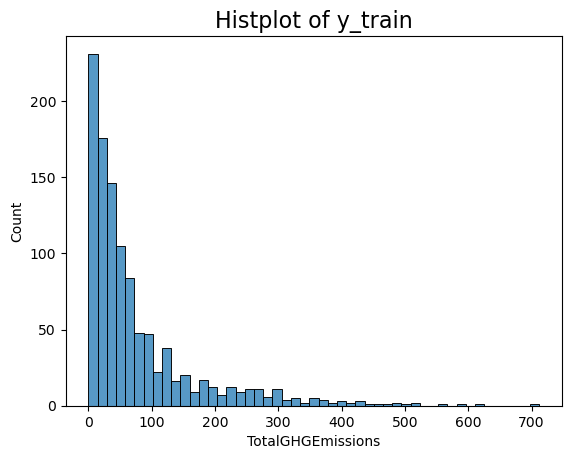

In [104]:
sns.histplot(y_train)
plt.title('Histplot of y_train', fontsize=16)
plt.show()

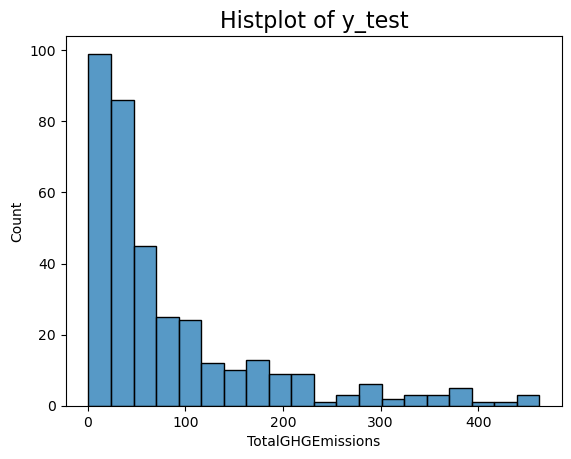

In [106]:
sns.histplot(y_test)
plt.title('Histplot of y_test', fontsize=16)
plt.show()

**Petit apperçu basique en préambule**

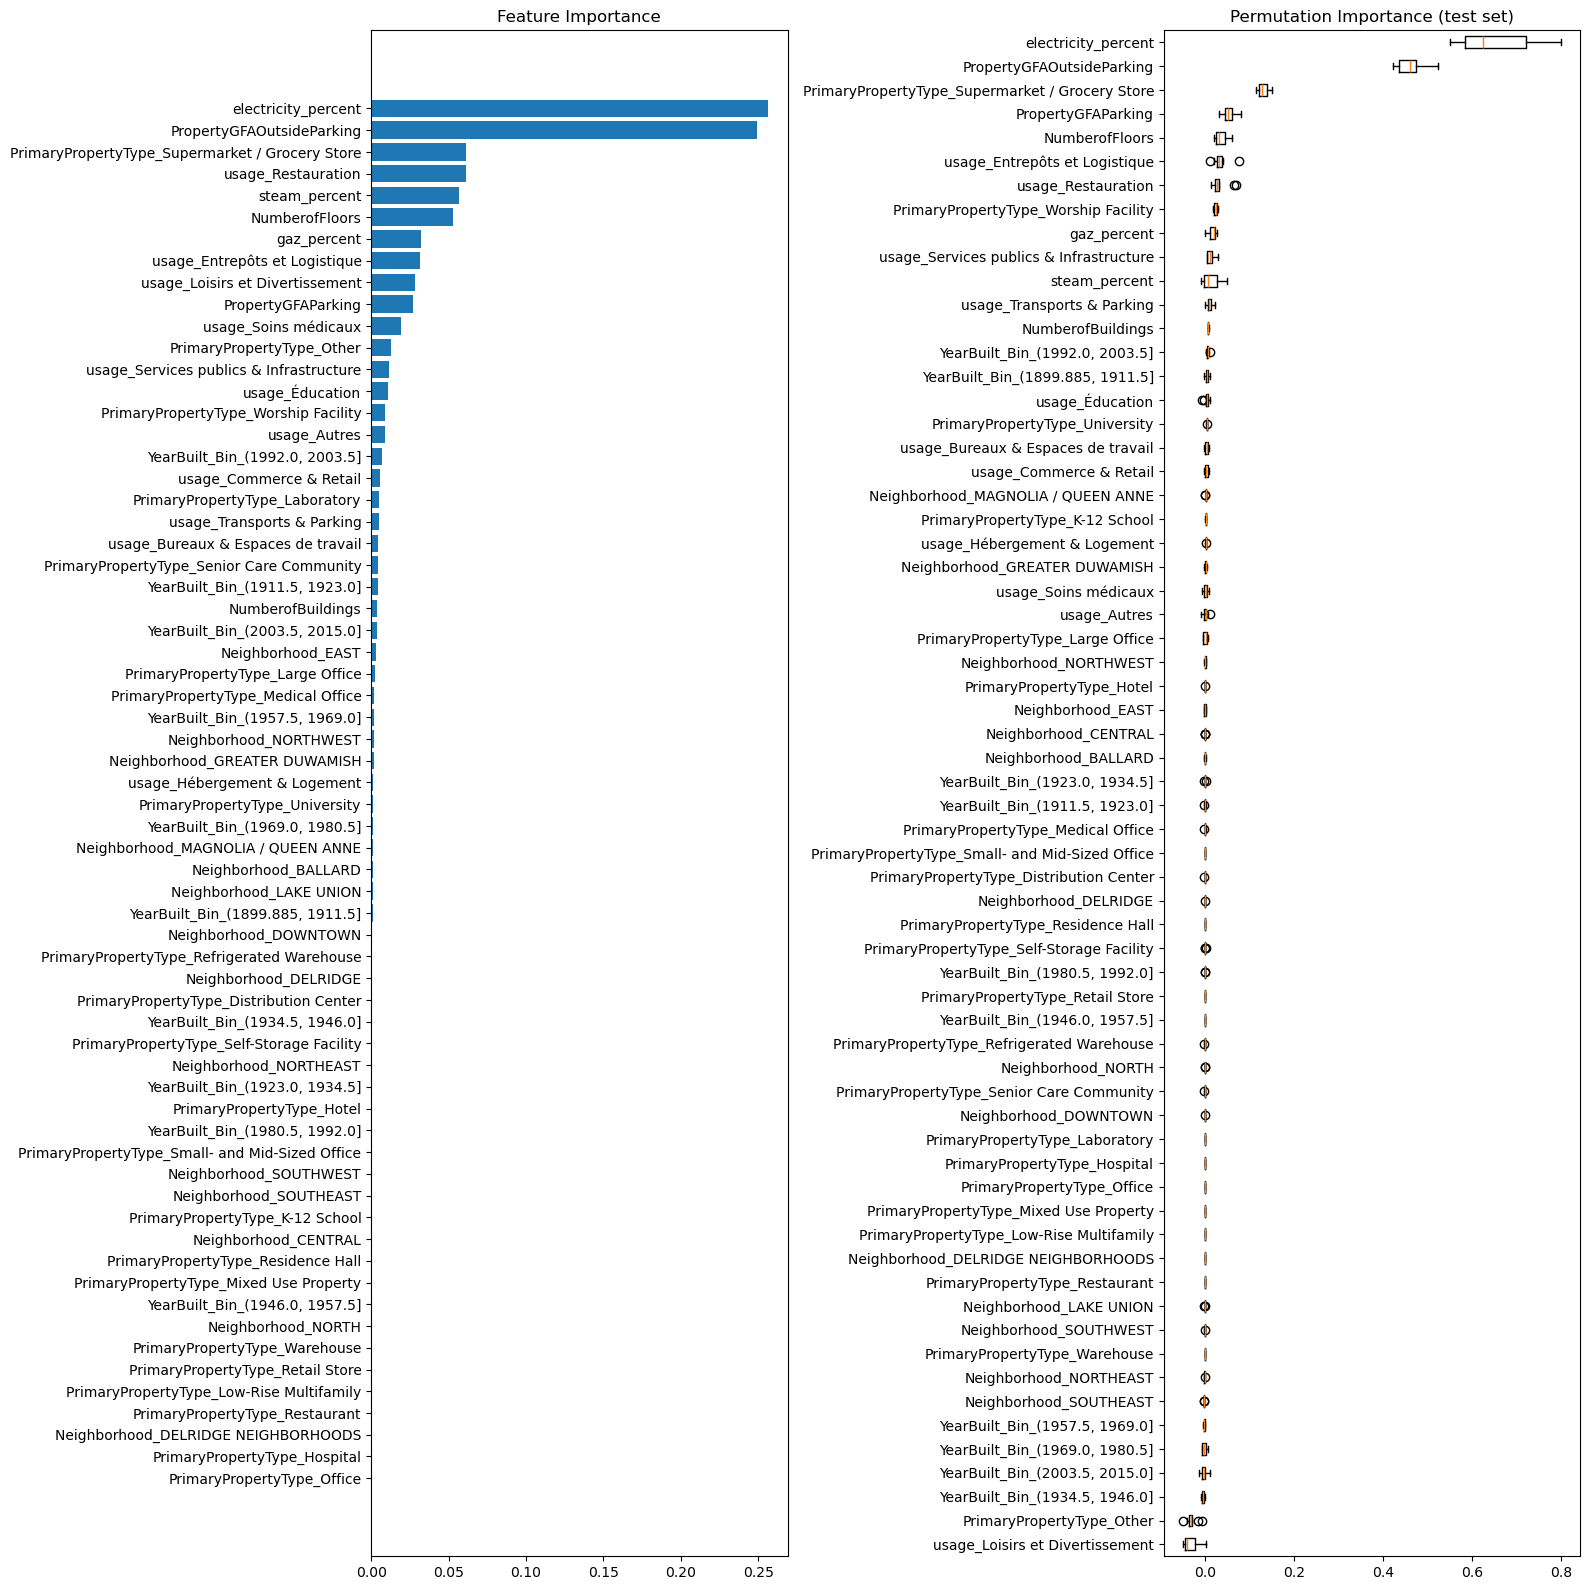

In [117]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_fe2.columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1, 2, 2)

# `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
# renamed to `tick_labels`. The following code handles this, but as a
# scikit-learn user you probably can write simpler code by using `labels=...`
# (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
tick_labels_parameter_name = (
    "tick_labels"
    if parse_version(matplotlib.__version__) >= parse_version("3.9")
    else "labels"
)
tick_labels_dict = {
    tick_labels_parameter_name: np.array(X_fe2.columns)[sorted_idx]
}
plt.boxplot(result.importances[sorted_idx].T, vert=False, **tick_labels_dict)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

On observe que :
- Le fait que electricity_percent domine indique que la proportion d'électricité dans le mix énergétique est un facteur clé dans les émissions de CO2.
- Les types de bâtiments ou leur aménagement influencent la quantité totale d'énergie utilisée, mais pas directement le mix énergétique (qui semble prédominer ici).
- Par exemple, un supermarché ou un entrepôt peut utiliser des proportions différentes d'électricité et de gaz, influençant les émissions.
- Contraitement à la prédiction de consommation d'energie, le pourcentage d'electricité est à une grande importance dans la prédiction des émissions. 
- La surface hors parking est également très importante pour la prédiction. Plus la surface est grande, plus les émissions sont susceptibles d'être élevées. 
- Les supermarchés ont généralement de grandes surfaces et consomment beaucoup d'électricity, peu voir pas du tout de gaz.
- Les restaurants consomment beaucoup de gaz, pour de faibles surfaces. C'est pourquoi il s'gagit d'une feature importante.

#### 3.2 - Création d’un objet explicatif (TreeExplainer)

Nous devrons créer un objet explicatif afin de tracer divers graphiques expliquant une prédiction particulière.

Nous allons commencer par créeTreearExplainer qui est couramment utilisé pour le gradient boosting regressor.

In [129]:
gradient_reg_explainer1 = shap.TreeExplainer(best_model, X_train)

Calculer les valeurs SHAP pour l'échantillon : Ces valeurs indiquent comment chaque caractéristique (ou feature) contribue à la prédiction en déviant de la "valeur de base" (ou base value, aussi appelée valeur attendue).

La valeur attendue représente la moyenne des prédictions du modèle (ou une autre valeur de référence) avant de tenir compte des caractéristiques spécifiques.

In [133]:
# Sélection de l’échantillon - L’échantillon à analyser est défini par son index dans X_test (ici, le premier échantillon)
sample_idx = 0

# Calcul des valeurs SHAP
shap_vals = gradient_reg_explainer1.shap_values(X_test[sample_idx])

print("Expected/Base Value : ", gradient_reg_explainer1.expected_value)   # Affichage de la valeur attendue (base value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)  # Montre les contributions des caractéristiques de l’échantillon au score final du modèle.
print("\n")
# Prédit la valeur pour cet échantillon à l’aide du modèle (gradient_reg_explainer1g)
# Attention le TreeExplainer n'a pas de fonction "predict", contrairement au LinearExplainer
print("Prediction From Model                            : ", best_model.predict(X_test[sample_idx].reshape(1, -1))[0])

# Vérifie que la somme de la valeur de base et des valeurs SHAP correspond exactement à la prédiction du modèle.
# Cela illustre que les valeurs SHAP décomposent correctement la prédiction du modèle.
print("Prediction From Adding SHAP Values to Base Value : ", gradient_reg_explainer1.expected_value + shap_vals.sum())

Expected/Base Value :  87.77970080070708

Shap Values for Sample 0 :  [-1.60637936e-01  2.49302885e-01  1.59277844e+01  2.53288445e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.98775120e-01
 -2.69148564e-02 -1.95188657e-01  0.00000000e+00  8.58402106e-02
  0.00000000e+00  9.63456940e-01 -1.08306044e+00  0.00000000e+00
 -5.06988581e-02 -1.91137272e+00  2.20657754e-02 -3.92134619e-02
  7.55824702e-02  0.00000000e+00 -6.41325861e-03 -9.54402679e-01
  0.00000000e+00  4.46764185e+00 -1.55703823e-01  0.00000000e+00
  0.00000000e+00 -5.94834468e-02  1.50117582e-01  0.00000000e+00
  8.40208651e+00  0.00000000e+00 -8.19843193e-01  1.57898092e-02
  0.00000000e+00 -1.63925180e+00 -1.02633203e-01  7.61701345e-02
  0.00000000e+00  0.00000000e+00  1.35865479e-01  0.00000000e+00
  0.00000000e+00 -3.13146422e+00 -5.26016673e-01  0.00000000e+00
  4.45372088e-01 -7.50359286e+01 -1.89342832e+00 -8.63386104e+00
 -1.22714420e+00 -4.99686027e-01 -1.45516740e+00  6.55751120e+00
 -5.06176312e-02 -2.

#### 3.3 - Diagrammes à barres

Le graphique à barres affiche les valeurs de shap de chaque entité pour un échantillon particulier de données. Vous trouverez ci-dessous une liste des paramètres importants de la méthode bar_plot() de shap.

POINTS CLES : PLUS LA BARRE EST GRANDE, PLUS L'IMPORTANCE EST GRANDE, 

et SURTOUT PAS PLUS LA BARRE EST GRANDE, PLUS LA VALEUR EST GRANDE.

shap_values : il accepte un tableau de valeurs shap pour un échantillon individuel de données.
feature_names - Il accepte une liste de noms de fonctionnalités.
max_display : il accepte les entiers spécifiant le nombre de fonctionnalités à afficher dans un graphique à barres.

Barres rouges (droite, contribution positive) : Ces caractéristiques augmentent la prédiction du modèle par rapport à la valeur de base (ou expected value). Elles poussent la prédiction vers une valeur plus élevée.

Barres bleues (gauche, contribution négative) : Ces caractéristiques diminuent la prédiction du modèle par rapport à la valeur de base. Elles tirent la prédiction vers une valeur plus basse.

Si la prédiction du modèle est une valeur élevée, on peut dire que cela est principalement dû à des valeurs élevées de PropertyGFAOutsideParking et PropertyGFAParking.
Les caractéristiques liées à l’électricité (par ex. electricity_percent) ont contribué à diminuer la prédiction.

Quelles sont les valeurs des features du 1er échantillon ?

In [140]:
# Associer noms et valeurs
for col, val in zip(X_fe2.columns, X_test[0]):
    print(f"{col}: {val}")

NumberofBuildings: -0.13173412742202079
NumberofFloors: 0.514151188771611
PropertyGFAParking: 2.7554152041374
Neighborhood_BALLARD: -0.21566554640687685
Neighborhood_CENTRAL: -0.18368486387701127
Neighborhood_DELRIDGE: -0.17544299181976059
Neighborhood_DELRIDGE NEIGHBORHOODS: -0.026361468712148235
Neighborhood_DOWNTOWN: -0.4814790443471277
Neighborhood_EAST: -0.27755746270091947
Neighborhood_GREATER DUWAMISH: -0.5420337065935641
Neighborhood_LAKE UNION: -0.3028797843376553
Neighborhood_MAGNOLIA / QUEEN ANNE: -0.3150184775872266
Neighborhood_NORTH: -0.21566554640687685
Neighborhood_NORTHEAST: 3.4771984543464143
Neighborhood_NORTHWEST: -0.2393088432694462
Neighborhood_SOUTHEAST: -0.17544299181976059
Neighborhood_SOUTHWEST: -0.16463334093438747
YearBuilt_Bin_(1899.885, 1911.5]: -0.34099716973523675
YearBuilt_Bin_(1911.5, 1923.0]: -0.29040893477575785
YearBuilt_Bin_(1923.0, 1934.5]: -0.32425604087826576
YearBuilt_Bin_(1934.5, 1946.0]: -0.18368486387701125
YearBuilt_Bin_(1946.0, 1957.5]: -0

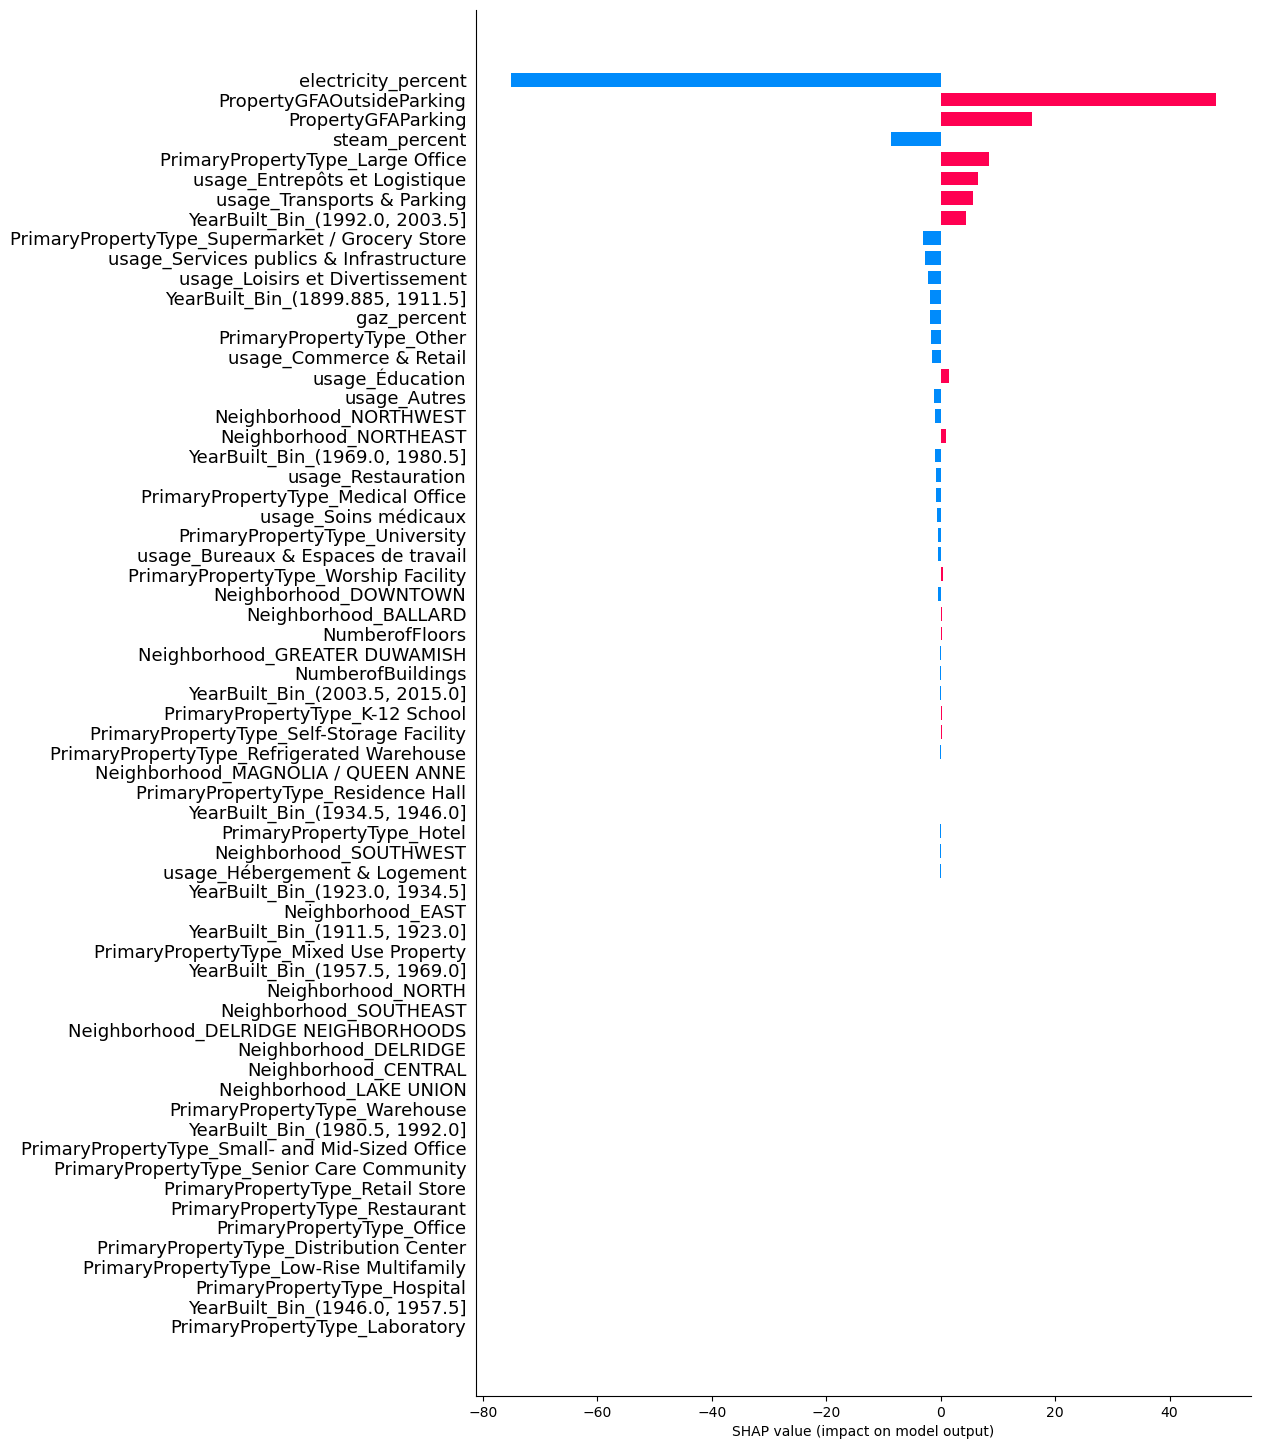

In [143]:
plt.figure(figsize=(10, 18))

shap.bar_plot(gradient_reg_explainer1.shap_values(X_test[0]),
              feature_names=X_fe2.columns,
              max_display=len(X_fe2.columns))

On voir clairement ici que les surfaces de parking et hors parking font monter les émissions, mais le pourcentage d'électricité et de vapeur fait diminuer les émissions, car ce sont des sources d'énergie à faible émission.

Regardons un 2ème échantillon :

In [148]:
# Associer noms et valeurs
for col, val in zip(X_fe2.columns, X_test[1]):
    print(f"{col}: {val}")

NumberofBuildings: -0.13173412742202079
NumberofFloors: -0.5530599273813545
PropertyGFAParking: -0.2876198020523373
Neighborhood_BALLARD: -0.21566554640687685
Neighborhood_CENTRAL: -0.18368486387701127
Neighborhood_DELRIDGE: -0.17544299181976059
Neighborhood_DELRIDGE NEIGHBORHOODS: -0.026361468712148235
Neighborhood_DOWNTOWN: -0.4814790443471277
Neighborhood_EAST: -0.27755746270091947
Neighborhood_GREATER DUWAMISH: 1.8449037169377274
Neighborhood_LAKE UNION: -0.3028797843376553
Neighborhood_MAGNOLIA / QUEEN ANNE: -0.3150184775872266
Neighborhood_NORTH: -0.21566554640687685
Neighborhood_NORTHEAST: -0.28758784208880117
Neighborhood_NORTHWEST: -0.2393088432694462
Neighborhood_SOUTHEAST: -0.17544299181976059
Neighborhood_SOUTHWEST: -0.16463334093438747
YearBuilt_Bin_(1899.885, 1911.5]: -0.34099716973523675
YearBuilt_Bin_(1911.5, 1923.0]: -0.29040893477575785
YearBuilt_Bin_(1923.0, 1934.5]: -0.32425604087826576
YearBuilt_Bin_(1934.5, 1946.0]: -0.18368486387701125
YearBuilt_Bin_(1946.0, 1957

Dans ce 2ème échantillon, : 
- le pourcentage d'électricité est beaucoup moins élevé que dans le 1er échantillon. Alors que le taux de gaz est plus élevé.
- la surface hors parking est plus faible dans le 2ème échantillon que dans le 1er.

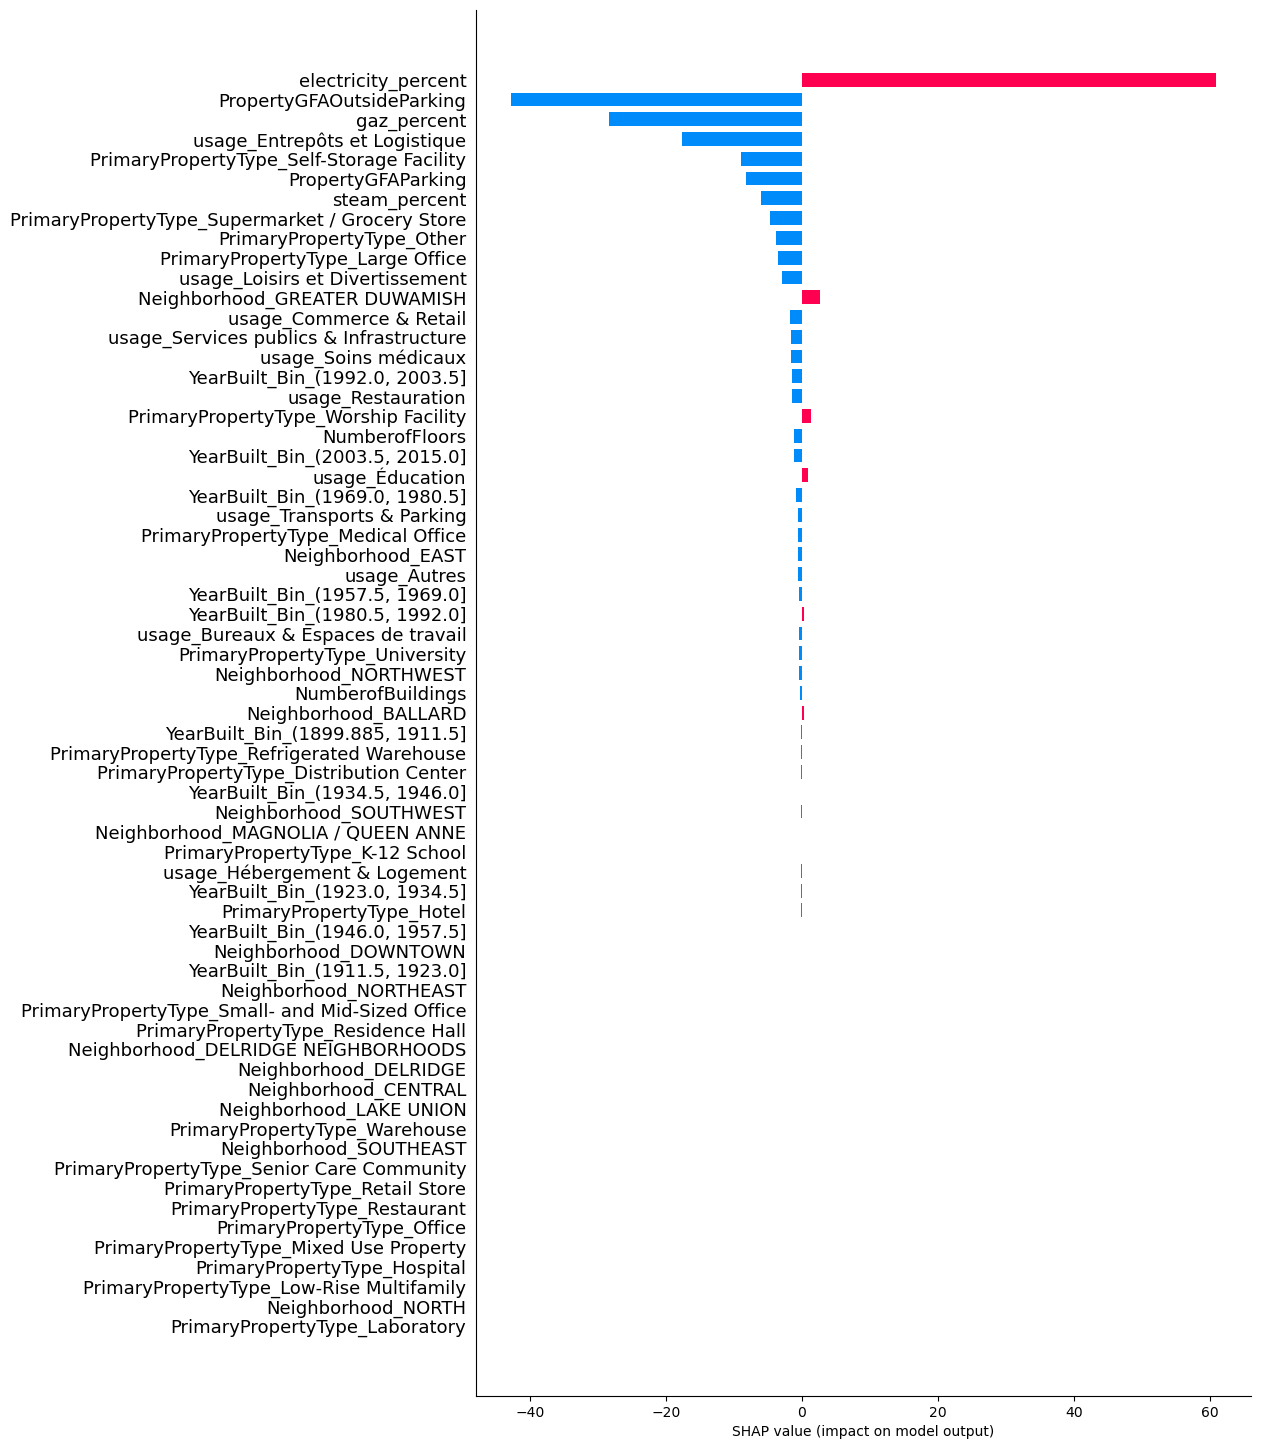

In [146]:
plt.figure(figsize=(10, 18))

shap.bar_plot(gradient_reg_explainer1.shap_values(X_test[1]),
              feature_names=X_fe2.columns,
              max_display=len(X_fe2.columns))

Constat :
- Moins d'électricité fait monter les émissions
- Plus la surface est grande, plus les émissions sont grandes
- Mais plus le pourcentage d'électricité est élevé, moins le taux d'émission est élevé.

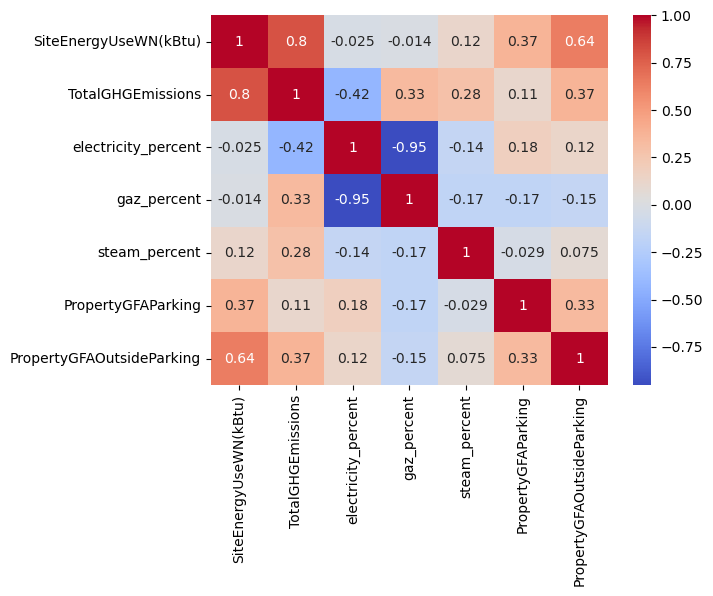

In [152]:
correlation_matrix = data_fe2[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'electricity_percent', 'gaz_percent', 'steam_percent', \
                           'PropertyGFAParking', 'PropertyGFAOutsideParking']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

On voit d'ailleurs sur la matrice de corrélation, que l'electricité est corrélée négativement aux émissions.

#### 3.4 - Tracé en cascade

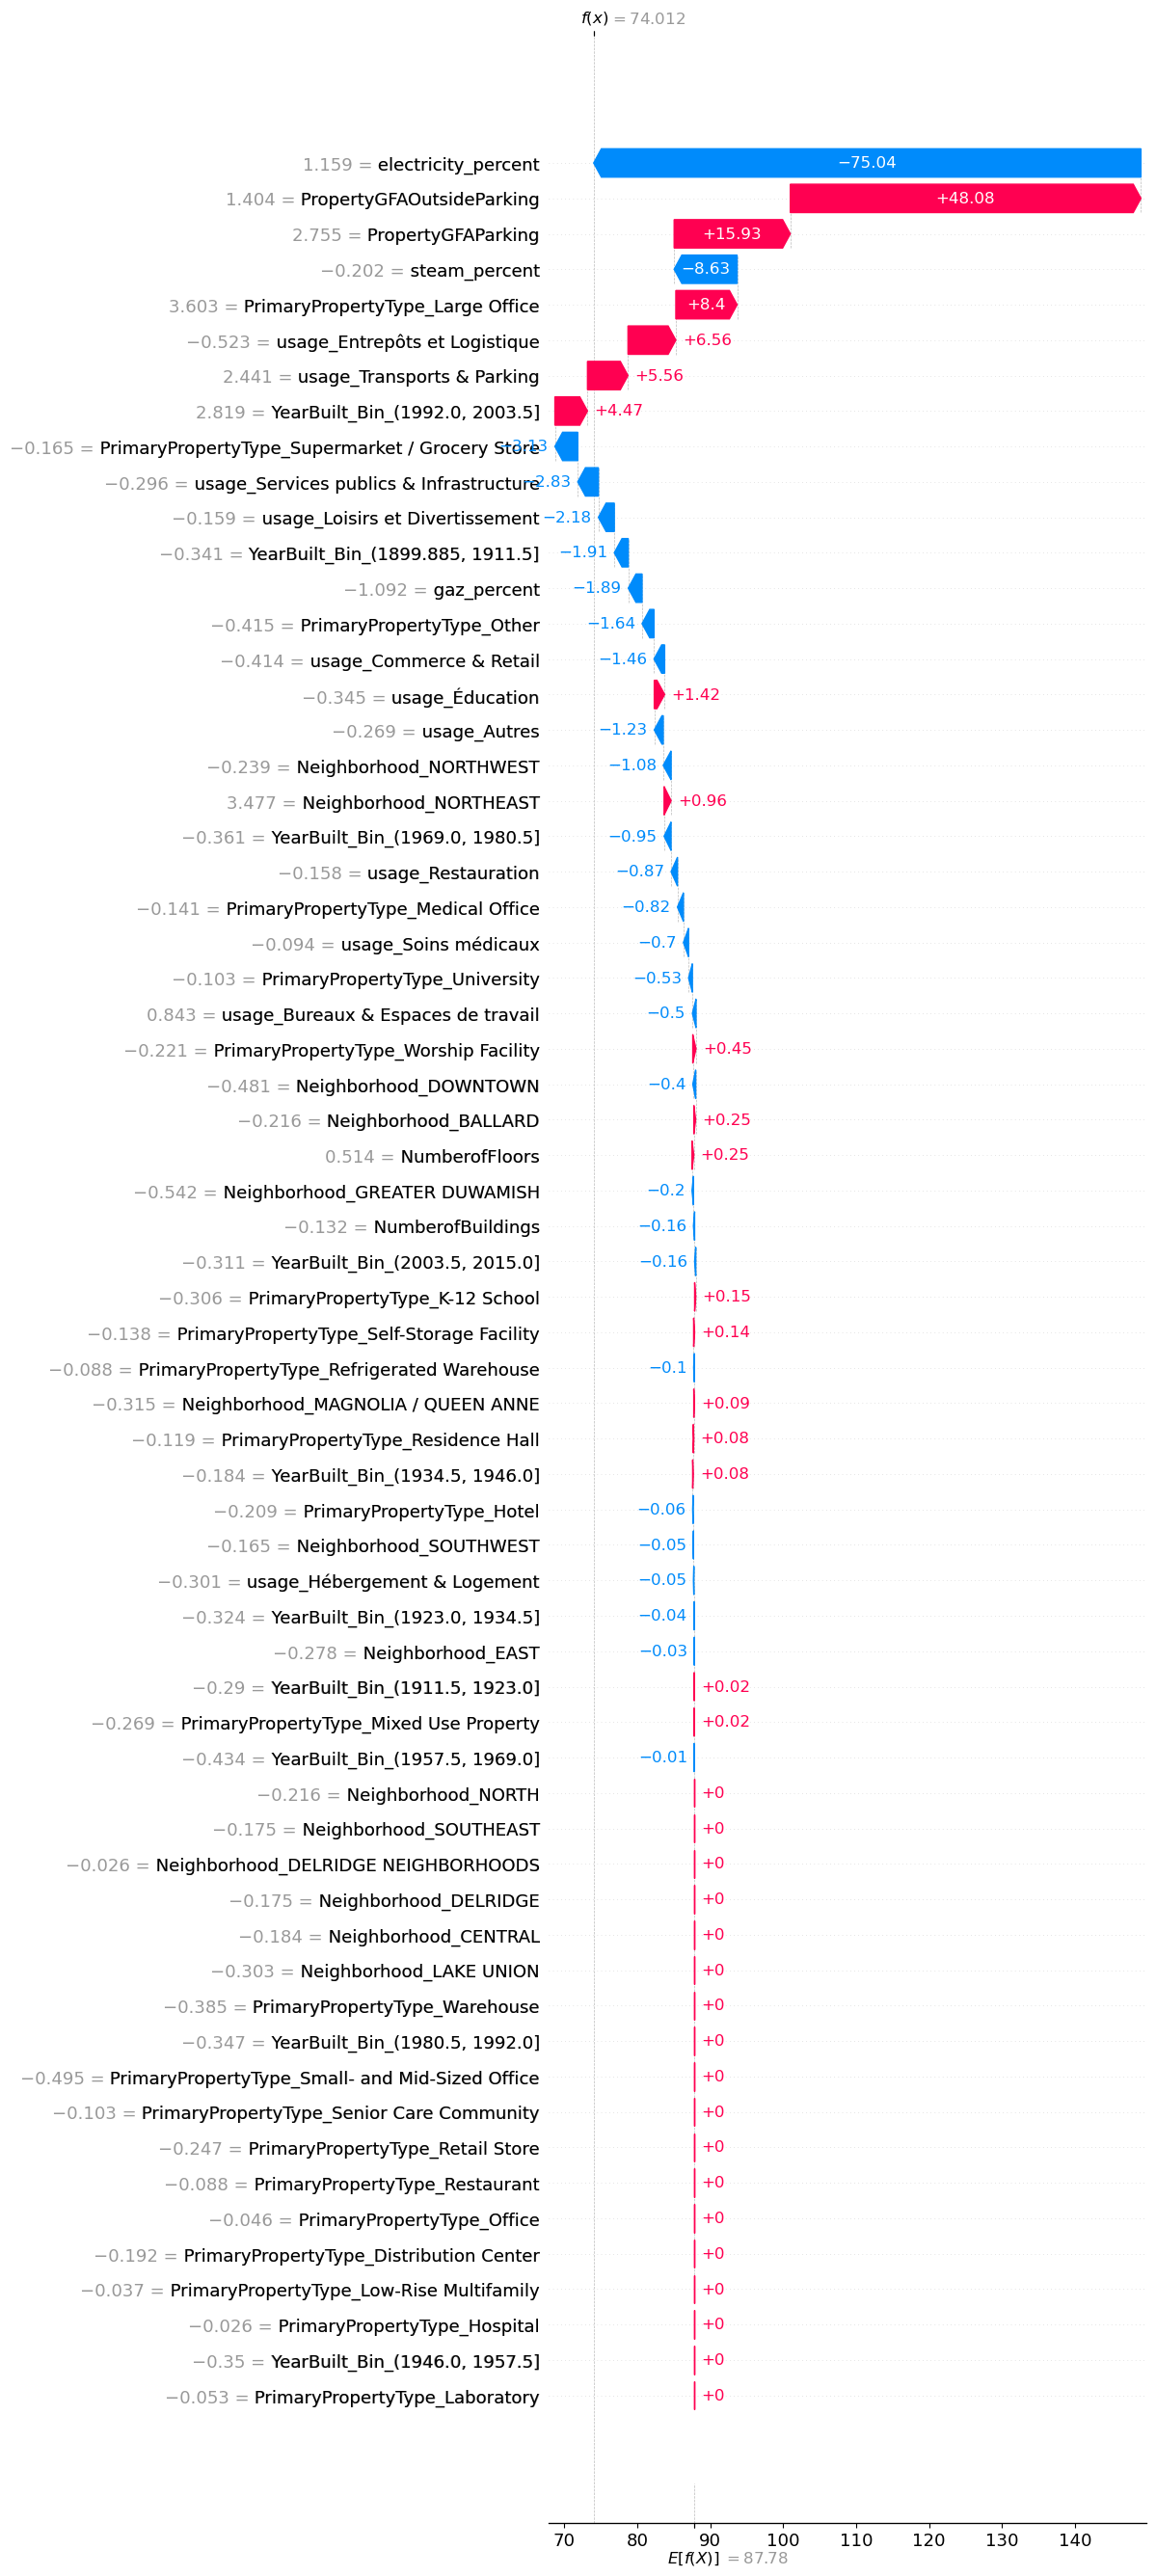

In [163]:
plt.figure(figsize=(60, 18))

shap_values = gradient_reg_explainer1(X_test[:1])
shap_values.feature_names = X_fe2.columns.tolist()

shap.waterfall_plot(shap_values[0], max_display=len(X_fe2.columns))

#### 3.5 - Diagramme de décision

D'abord sur un échantillon :

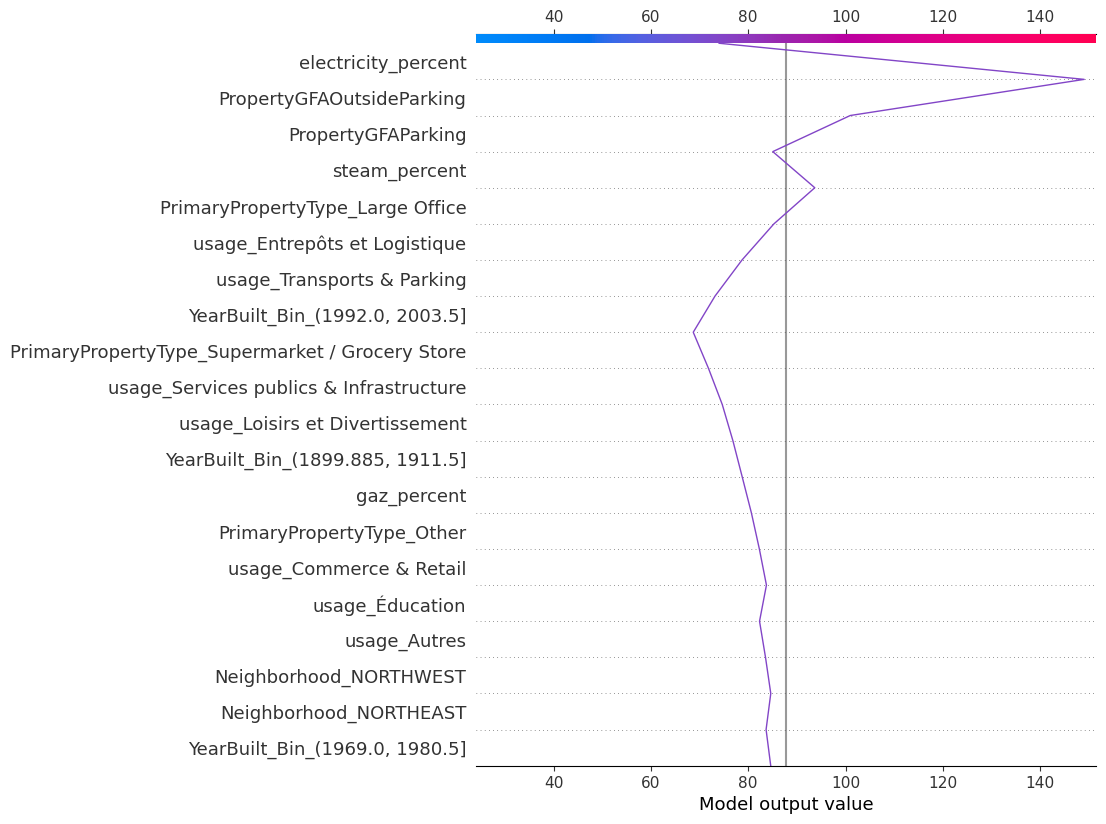

In [168]:
shap.decision_plot(gradient_reg_explainer1.expected_value,
                   gradient_reg_explainer1.shap_values(X_test[0]),
                   feature_names=X_fe2.columns.tolist(),
                   )

Puis sur 2O échantillons :

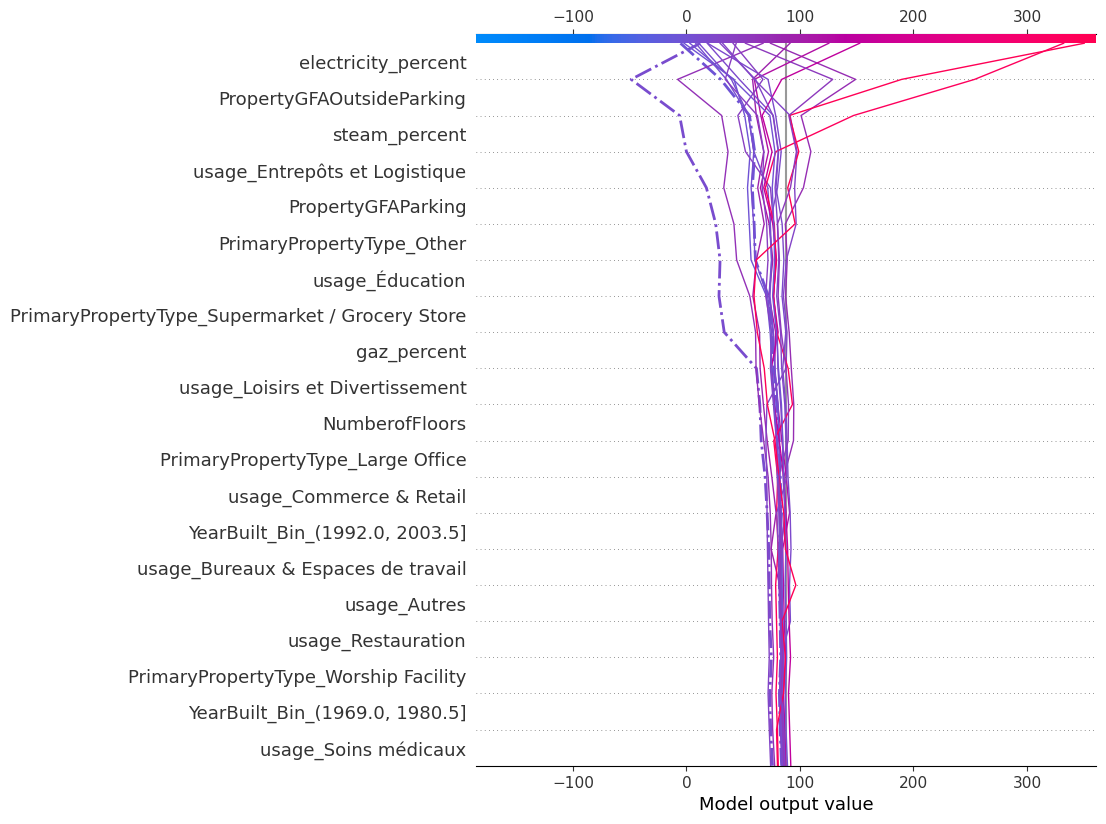

In [173]:
shap.decision_plot(gradient_reg_explainer1.expected_value,
                   gradient_reg_explainer1.shap_values(X_test[0:20]),
                   feature_names=X_fe2.columns.tolist(),
                   highlight=[1, 2],
                   )